# Yelp Review Prediction
Objective: Construct and train a Neural Network that would be able to predict the number of star ratings from a Yelp review.    
Dataset used: https://www.yelp.com/dataset/challenge  

Steps:  
1) Data Preprocessing  
2) Deep Learning Preprocessing  
3) Network Training  
4) Network Testing  

In [235]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
from langdetect import detect
import time
import numpy as np
import pandas as pd
from pandas_ml import ConfusionMatrix
import seaborn

import sklearn as sk
from sklearn.model_selection import train_test_split
import numpy as np
import json

import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
import pickle

import matplotlib.pyplot as plt
import random
import nltk, re, time
from nltk.corpus import stopwords
import string
from collections import defaultdict

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical
from collections import namedtuple

from contractions import get_contractions
import operator
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import tensor_array_ops
print('TensorFlow Version: {}'.format(tf.__version__))

alreadyPickled = False

TensorFlow Version: 1.4.0


## Variable Initialization

In [236]:
embedding_dim = 300
num_layers = 2
num_classes = 6
epochs = 2
batch_size = 64
rnn_size = 64
num_layers = 2

learning_rate = 0.005

keep_probability = 0.8
max_sequence_length = 700

IS_TRAINING = True
IS_TESTING = False

## Data Preprocessing
The following few cells preprocess the data for me. Clean test defines a function where it removes stop_words (found here https://gist.github.com/sebleier/554280). These words typically have no beneficial meaning to any reviews and are thus wasted features. I also strip punctuation and turn everything lower case. These procedures can be considered pretty standard

In [237]:
def clean_text(text, remove_stopwords = True):
    
    assert isinstance(text, unicode)
    
    text = text.lower()    
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    return text

In [88]:
restId = []
for line in open('./data/dataset/business.json', 'r'):
    data = json.loads(line)
    if 'Restaurants' in data['categories'] or 'Food' in data['categories']:
        restId.append(data['business_id'])
print("There are %d restaurants" % (len(restId)))

There are 65028 restaurants


### Grabbing the reviews and star ratings

In [284]:
contractions = get_contractions()

revs_list = [[]]
stars_list = [[]]
num = 5000 # Number of review read
k = 0 # Count
for line in open('./data/dataset/review.json', 'r'):
    if k >= num:
        break
    data = json.loads(line)
    text = data['text']
    star = data['stars']
    ID = data['business_id']
    # Check language
    if detect(text) != 'en':
        continue  
    # Check whether it is a restaurant
    if ID not in restId:
        continue

    revs_list.append(clean_text(text))
    stars_list.append(star)
    k += 1
    # Notify for every 500 reviews
    if len(revs_list) % 500 == 0:
        print(len(revs_list))

In [93]:
print(revs_list[1])
print(len(revs_list), len(stars_list))

place horrible excited try since got gift card birthday went ordered whole meal except gift card system unacceptable would helpful would known prior
1045 1045


In [94]:
zipped_revs = zip(revs_list, stars_list)
print("Shape of Ziped Revs is [%d, %d]" % (len(zipped_revs), len(zipped_revs[0])))
categories = ['text', 'stars']

df_reviews_processing = pd.DataFrame(zipped_revs, columns=categories)


Shape of Ziped Revs is [1045, 2]


In [95]:
df_reviews_processing.shape
df_reviews_processing.head()
df_reviews_processing[['stars']] = df_reviews_processing[['stars']].apply(pd.to_numeric)

# Grabbing only numbers that are of numerical value (get rid of None, NaN, etc)
df_reviews_processing = df_reviews_processing[np.isfinite(df_reviews_processing['stars'])]

print("Before Dropping Nones: Shape %d,%d" % (df_reviews_processing.shape[0], df_reviews_processing.shape[1]))
df_reviews = df_reviews_processing[np.isfinite(df_reviews_processing['stars'])]
print("After Dropping Nones: Shape %d,%d" % (df_reviews.shape[0], df_reviews.shape[1]))

df_reviews.to_csv("reviews_df_processed.csv", encoding='utf-8')



Before Dropping Nones: Shape 1044,2
After Dropping Nones: Shape 1044,2


# Data Loading
If the data is already pickled, then can skip embedding and data processing

In [96]:
def picklefiles(filename, stuff):
    save_stuff = open(filename, "wb")
    pickle.dump(stuff, save_stuff)
    save_stuff.close()
def loadfiles(filename):
    saved_stuff = open(filename,"rb")
    stuff = pickle.load(saved_stuff)
    saved_stuff.close()
    return stuff

# Embeddings
Using ConceptNet Numberbatch instead of GLoVE (supposedly outperforms GLoVE embeddings)  
https://github.com/commonsense/conceptnet-numberbatch
  
On top of the embeddings, we also keep track of commonly used words in the reviews that Embeddings don't cover. This way we could have higher test accuracy when words we come across words like these. This is specified by a threshold value. Currently, threshold is set to 20 occuraces.  
  
  
We also process the reviews a bit more, sorting them into comparable lengths. This way, there is less padding necessary and (possibly) faster computation time when training/testing

In [97]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [98]:
word_counts = {}
count_words(word_counts, df_reviews.text)            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 7260


In [99]:
embed_path='./embeddings/numberbatch-en-17.02.txt'
def load_embeddings(path='./embeddings/numberbatch-en-17.02.txt'):
    embeddings_index = {}
    with open(path) as f:
        for line in f:
            values = line.split(' ')
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = embedding
    return embeddings_index

embeddings_index = load_embeddings(embed_path)

# Balance the Dataset
Want to balance the dataset, such that we have an equal number of reviews for each different category.  
For example, if our distribution of reviews is [200,500,100,300,400], for [1,2,3,4,5] stars, respectively, then I will only take 100 of each review  
I do this so we have an equal representation of all labels when he train and test

In [238]:
def balance_dataframe(df, category=['stars'], downsample_by=0.9):
    """
    :param df: pandas.DataFrame
    :param categorical_columns: iterable of categorical columns names contained in {df}
    :return: balanced pandas.DataFrame
    """
    
    assert isinstance(df, pd.DataFrame)
    if category is None or not all([col in df.columns for col in category]):
        raise ValueError('Please provide one or more columns containing categorical variables')

    lowest_count = df.groupby(category).apply(lambda x: x.shape[0]).min()
    # Remove 10 percent of the reviews
    lowest_count = int(lowest_count * downsample_by)
    
    df = df.groupby(category).apply( 
        lambda x: x.sample(lowest_count)).drop(category, axis=1).reset_index().set_index('level_1')

    df.sort_index(inplace=True)

    return df

In [239]:
df_reviews = pd.read_csv("./data/reviews_df_processed100k.csv")
df_reviews['len'] = df_reviews.text.str.len()

df_reviews = df_reviews[df_reviews['len'].between(10, 4000)]
df_reviews[['stars']] = df_reviews[['stars']].apply(pd.to_numeric)

print("(pre) 1 star ratings: %d" % (len(df_reviews[df_reviews.stars == 1])))
print("(pre) 2 star ratings: %d" % (len(df_reviews[df_reviews.stars == 2])))
print("(pre) 3 star ratings: %d" % (len(df_reviews[df_reviews.stars == 3])))
print("(pre) 4 star ratings: %d" % (len(df_reviews[df_reviews.stars == 4])))
print("(pre) 5 star ratings: %d" % (len(df_reviews[df_reviews.stars == 5])))

# Set downsample_by to 0.9, since not much training data to begin with
df_balanced = balance_dataframe(df_reviews, 
                                category=['stars'], 
                                downsample_by=0.9)

df_balanced.to_csv('balanced_reviews1000.csv', encoding='utf-8')
print("(post) 1 star ratings: %d" % (len(df_balanced[df_balanced.stars == 1])))
print("(post) 2 star ratings: %d" % (len(df_balanced[df_balanced.stars == 2])))
print("(post) 3 star ratings: %d" % (len(df_balanced[df_balanced.stars == 3])))
print("(post) 4 star ratings: %d" % (len(df_balanced[df_balanced.stars == 4])))
print("(post) 5 star ratings: %d" % (len(df_balanced[df_balanced.stars == 5])))




(pre) 1 star ratings: 11399
(pre) 2 star ratings: 10085
(pre) 3 star ratings: 14640
(pre) 4 star ratings: 27767
(pre) 5 star ratings: 36104
(post) 1 star ratings: 9076
(post) 2 star ratings: 9076
(post) 3 star ratings: 9076
(post) 4 star ratings: 9076
(post) 5 star ratings: 9076


In [240]:
df_balanced.head()
print(np.percentile(df_balanced.len, 80))
print(np.percentile(df_balanced.len, 85))
print(np.percentile(df_balanced.len, 87.5))
print(np.percentile(df_balanced.len, 95))


592.0
690.0
753.0
1089.0


In [243]:
embedding_dim = 300 # Matches CN embedding file
MAX_NB_WORDS = 15000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_balanced.text.tolist())

WORD_INDEX_SORTED = sorted(tokenizer.word_index.items(), key=operator.itemgetter(1))
print("number of words is %d" % (len(WORD_INDEX_SORTED)))

vocab_size = len(WORD_INDEX_SORTED)+1

NB_WORDS = min(len(WORD_INDEX_SORTED), MAX_NB_WORDS)

word_embedding_matrix = np.zeros((NB_WORDS, embedding_dim), dtype=np.float32)

for word, i in tokenizer.word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i-1] = embedding_vector
print("embedding matrix size: is [%d,%d]" % (word_embedding_matrix.shape[0], 
                                            word_embedding_matrix.shape[1]))

number of words is 47647
embedding matrix size: is [15000,300]


In [244]:
sequences = tokenizer.texts_to_sequences(df_balanced.text.values)
# Pad the reviews so that they are all of the same length
padReviews = pad_sequences(sequences, maxlen=max_sequence_length)
reviewsLength = max_sequence_length

# Split the ratings into OneHot representation
ratings = df_balanced.stars.values.astype(int)
ratings_cat = to_categorical(ratings)

X_train, X_test, y_train, y_test = train_test_split(padReviews, ratings_cat, test_size=0.2, random_state=9)
with pd.HDFStore('x_y_test_train.h5') as h:
    h['X_train'] = pd.DataFrame(X_train)
    h['X_test'] = pd.DataFrame(X_test)
    h['y_train'] = pd.DataFrame(y_train)
    h['y_test'] = pd.DataFrame(y_test)

assert padReviews.shape[0] == ratings.shape[0] 

In [245]:
print(type(ratings_cat))
print(type(X_train))
print(ratings_cat.shape)
print(X_train.shape)
print(y_train.shape)

<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(45380, 6)
(36304, 700)
(36304, 6)


In [246]:
if alreadyPickled == False:
    
    picklefiles("./data/good_pickles/balanced_reviews100k.p",df_balanced)
    picklefiles("./data/good_pickles/category_ratings100k.p",ratings_cat)
    picklefiles("./data/good_pickles/word_embedding_matrix100k.p",word_embedding_matrix)
    picklefiles("./data/good_pickles/tokenizer100k.p", tokenizer)
    
if alreadyPickled == True:
    
    word_embedding_matrix = loadfiles("./data/word_embedding_matrix.p")
    df_rev_balanced = pd.read_csv('balanced_reviews.csv')
    ratings_cat = loadfiles("./data/good_pickles/category_ratings.p")
    balanced_reviews = loadfiles("./data/good_pickles/balanced_reviews.p")
    tokenizer = loadfiles('tokenizer.pickle')
    with pd.HDFStore('x_y_test_train.h5') as h:
        X_train = h['X_train'].values
        X_test = h['X_test'].values
        y_train = h['y_train'].values
        y_test = h['y_test'].values

# Getting Batches
Gets batches. These will be called later to then fill our X and y placeholders

In [247]:
def get_batches(x, y, batch_size):
    assert isinstance(batch_size, int)
    assert isinstance(x, np.ndarray) and isinstance(y, np.ndarray)
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size,:], y[ii:ii+batch_size]
        
def get_test_batches(x, batch_size):
    
    assert isinstance(batch_size, int)
    assert isinstance(x, np.ndarray)
    
    n_batches = len(x)//batch_size
    x = x[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size,:]

In [225]:
# Display some data vectors here and their type
for batch_i, (trainX_batch, trainY_batch) in enumerate(get_batches(X_train, y_train, batch_size)):
    print(trainX_batch.shape)
    print(trainY_batch.shape)
    if batch_i == 0:
        break

(128, 850)
(128, 6)


# Building the Graph
Here we start building our computational graph. We use a 2 layer GRU Recurrent Neural Network. We define placeholders for learning rate and dropout since these are variables that we could potentially want to vary.

In [248]:
def model_inputs():
    # Should be [batch_size x review length]
#     with tf.name_scope("input_data"):
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
#         tf.summary.scalar('input_data', input_data)
        
    # Should be [batch_size x num_classes]
#     with tf.name_scope("labels"):
    labels = tf.placeholder(tf.int32, [None, None], name='labels')
#         tf.summary.scalar('labels', labels)
        
#     with tf.name_scope("lr"):    
    lr = tf.placeholder(tf.float32, name='learning_rate')
#         tf.summary.scalar("lr", labels)
    
#     with tf.name_scope("keep_prob"):
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
#         tf.summary.scalar("keep_prob", keep_prob)

    return input_data, labels, lr, keep_prob

In [249]:
def extract_axis_1(data, ind):
    """
    Get specified elements along the first axis of tensor.
    :param data: Tensorflow tensor that will be subsetted.
    :param ind: Indices to take (one for each element along axis 0 of data).
    :return: Subsetted tensor.
    """

    batch_range = tf.range(tf.shape(data)[0])
    indices = tf.stack([batch_range, ind], axis=1)
    res = tf.gather_nd(data, indices)

    return res

In [259]:
# Reset the graph
tf.reset_default_graph()

In [260]:
train_graph = tf.Graph()
with train_graph.as_default():
    with tf.name_scope("inputs"):
        input_data, labels, lr, keep_prob = model_inputs()
    
    print("Shape of Input Data")
    print(tf.shape(input_data))
    embeddings = word_embedding_matrix
    embs = tf.nn.embedding_lookup(embeddings, input_data)

    with tf.name_scope("RNN_Layers"):
        
        stacked_rnn = []
        for layer in range(num_layers):
            cell_fw = tf.contrib.rnn.GRUCell(rnn_size)
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw,
                                                    output_keep_prob=keep_prob)
            stacked_rnn.append(cell_fw)
        multilayer_cell = tf.contrib.rnn.MultiRNNCell(stacked_rnn, state_is_tuple=True)

        
    with tf.name_scope("init_state"):
        initial_state = multilayer_cell.zero_state(batch_size, tf.float32)

    with tf.name_scope("Forward_Pass"):
        output, final_state = tf.nn.dynamic_rnn(multilayer_cell,
                                           embs,
                                           dtype=tf.float32)
#     with tf.name_scope("FC_Layer"):
#         dense = tf.contrib.layers.fully_connected(output[:,-1],
#                                                   num_outputs = 64,
#                                                   activation_fn = tf.sigmoid,
#                                                   weights_initializer = tf.random_normal_initializer())
        
#         dense = tf.contrib.layers.dropout(dense, keep_prob)
    with tf.name_scope("Predictions"):
        weight = tf.Variable(tf.truncated_normal([rnn_size, num_classes]))
        bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
#         value = tf.transpose(output, [1, 0, 2])
#         last = extract_axis_1(output, rnn_size - 1)
        last = output[:, -1, :]
#         last = final_state.output #tf.gather(value, int(value.get_shape()[0]) - 1)
        
        predictions = (tf.matmul(last, weight) + bias)
        
        
#         predictions = tf.contrib.layers.fully_connected(output[:,-1],
#                                                         num_outputs = num_classes, 
#                                                         activation_fn=tf.nn.sigmoid,
#                                                         weights_initializer = tf.random_normal_initializer())
#         predictions = tf.layers.dense(dense,
#                                      units = num_classes,
#                                      activation=tf.nn.sigmoid,
#                                      trainable=True)
#         predictions = tf.one_hot(tf.argmax(predictions, axis=1), depth=num_classes)
        tf.summary.histogram('predictions', predictions)
        
    with tf.name_scope('cost'):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=labels))        
#         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=labels))
        tf.summary.scalar('cost', cost)
    
    # Optimizer 
    with tf.name_scope('train'):    
        optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    # Predictions comes out as 6 output layer, so need to "change" to one hot
    with tf.name_scope("accuracy"):
        correctPred = tf.equal(tf.argmax(predictions,1), tf.argmax(labels,1))
        accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))
        
#         accuracy = tf.metrics.accuracy(tf.argmax(labels,1), tf.argmax(predictions,1))
#         correct = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
#         accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        
#         correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels)
#         accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        tf.summary.scalar('accuracy', accuracy)
    
    export_nodes = ['input_data', 'labels', 'keep_prob', 'lr', 'initial_state', 'final_state',
                    'accuracy', 'predictions', 'cost', 'optimizer', 'merged']
    
    merged = tf.summary.merge_all()
    
print("Graph is built.")
graph_location = "./graph"

Graph = namedtuple('train_graph', export_nodes)
local_dict = locals()
graph = Graph(*[local_dict[each] for each in export_nodes])
    
print(graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(train_graph)


Shape of Input Data
Tensor("Shape:0", shape=(2,), dtype=int32)
Graph is built.
./graph


In [252]:
print(tf.shape(output))
print(tf.shape(embs))
print(tf.shape(predictions))
print(y_train[0:10])
print(predictions.dtype)

Tensor("Shape_1:0", shape=(3,), dtype=int32)
Tensor("Shape_2:0", shape=(3,), dtype=int32)
Tensor("Shape_3:0", shape=(2,), dtype=int32)
[[ 0.  0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.]]
<dtype: 'float32'>


## Defining Hyperparameters

In [253]:
learning_rate_decay = 0.95
min_learning_rate = 0.0005
display_step = 10 # Check training loss after every 20 batches
stop_early = 0 
stop = 3 # If the update loss does not decrease in 3 consecutive update checks, stop training
per_epoch = 5 # Make 3 update checks per epoch
update_check = (len(X_train)//batch_size//per_epoch)-1
keep_probability = 0.75
update_loss = 0 
batch_loss = 0
summary_update_loss = [] # Record the update losses for saving improvements in the model

# Training the Model
I've been keeping track of the tensorboard summaries so it'll allow me to visualize the training process. 

In [254]:
checkpoint = "./saves/best_model_100k.ckpt" 
if IS_TRAINING:
    with tf.Session(graph=train_graph) as sess:
        sess.run(tf.global_variables_initializer())

    #     loader = tf.train.import_meta_graph("./" + checkpoint + '.meta')
    #     loader.restore(sess, checkpoint)


        train_writer = tf.summary.FileWriter('./summaries' + '/train' + '/100k/run7/', sess.graph)

        for epoch_i in range(1, epochs+1):
            state = sess.run(graph.initial_state)

            update_loss = 0
            batch_loss = 0

            for batch_i, (x, y) in enumerate(get_batches(X_train, y_train, batch_size), 1):
                if batch_i == 1:
                    print("Starting")
                feed = {graph.input_data: x,
                        graph.labels: y,
                        graph.keep_prob: keep_probability,
                        graph.initial_state: state}
                start_time = time.time()
                summary, loss, acc, state, _ = sess.run([graph.merged, 
                                                         graph.cost, 
                                                         graph.accuracy, 
                                                         graph.final_state, 
                                                         graph.optimizer], 
                                                        feed_dict=feed)
                if batch_i == 1:
                    print("Finished first")

                train_writer.add_summary(summary, epoch_i*batch_i + batch_i)

                batch_loss += loss
                update_loss += loss
                end_time = time.time()
                batch_time = end_time - start_time

                if batch_i % display_step == 0 and batch_i > 0:
                    print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}, Acc: {:>6.3f}, Seconds: {:>4.2f}'
                          .format(epoch_i,
                                  epochs, 
                                  batch_i, 
                                  len(X_train) // batch_size, 
                                  batch_loss / display_step,
                                  acc,
                                  batch_time*display_step))
                    batch_loss = 0

                if batch_i % update_check == 0 and batch_i > 0:
                    print("Average loss for this update:", round(update_loss/update_check,3))
                    summary_update_loss.append(update_loss)

                    # If the update loss is at a new minimum, save the model
                    if update_loss <= min(summary_update_loss):
                        print('New Record!') 
                        stop_early = 0
                        saver = tf.train.Saver() 
                        saver.save(sess, checkpoint)

                    else:
                        print("No Improvement.")
                        stop_early += 1
                        if stop_early == stop:
                            break
                    update_loss = 0


            # Reduce learning rate, but not below its minimum value
            learning_rate *= learning_rate_decay
            if learning_rate < min_learning_rate:
                learning_rate = min_learning_rate

            if stop_early == stop:
                print("Stopping Training.")
                break

Starting
Finished first
Epoch   1/2 Batch   10/567 - Loss:  1.703, Acc:  0.203, Seconds: 17.46
Epoch   1/2 Batch   20/567 - Loss:  1.654, Acc:  0.219, Seconds: 16.31
Epoch   1/2 Batch   30/567 - Loss:  1.656, Acc:  0.188, Seconds: 15.64
Epoch   1/2 Batch   40/567 - Loss:  1.614, Acc:  0.250, Seconds: 18.95
Epoch   1/2 Batch   50/567 - Loss:  1.613, Acc:  0.156, Seconds: 15.84
Epoch   1/2 Batch   60/567 - Loss:  1.592, Acc:  0.250, Seconds: 18.26
Epoch   1/2 Batch   70/567 - Loss:  1.605, Acc:  0.188, Seconds: 20.38
Epoch   1/2 Batch   80/567 - Loss:  1.596, Acc:  0.188, Seconds: 22.25
Epoch   1/2 Batch   90/567 - Loss:  1.543, Acc:  0.328, Seconds: 16.40
Epoch   1/2 Batch  100/567 - Loss:  1.503, Acc:  0.281, Seconds: 16.03
Epoch   1/2 Batch  110/567 - Loss:  1.476, Acc:  0.406, Seconds: 23.00
Average loss for this update: 1.594
New Record!
Epoch   1/2 Batch  120/567 - Loss:  1.505, Acc:  0.312, Seconds: 16.86
Epoch   1/2 Batch  130/567 - Loss:  1.532, Acc:  0.438, Seconds: 15.74
Epoch

Epoch   2/2 Batch  540/567 - Loss:  1.147, Acc:  0.609, Seconds: 19.57
Epoch   2/2 Batch  550/567 - Loss:  1.192, Acc:  0.391, Seconds: 18.62
Epoch   2/2 Batch  560/567 - Loss:  1.221, Acc:  0.484, Seconds: 25.60
Average loss for this update: 1.187
New Record!


# Testing the Data
This part of the code is allocated to testing the data. On top of recording accuracy results, I also generate a confusion matrix. Since reviews are subjective and aren't concretely one rating or another, a confusion matrix helps visualize your results a lot better

In [257]:
IS_TESTING = True

In [280]:
if IS_TESTING:
    with tf.Session(graph=train_graph) as sess:
        y_true = y_test.argmax(axis=1)
        checkpoint = "./saves/best_model_100k.ckpt"  

        all_preds = []

        with tf.Session() as sess:
            saver = tf.train.Saver()
            # Load the model
            saver.restore(sess, checkpoint)
            test_state = sess.run(graph.initial_state)

            for ii, x in enumerate(get_test_batches(X_test, batch_size), 1):
                if ii%50==0:
                    print("%d batches"%(ii*batch_size))
                feed = {graph.input_data: x,
                        graph.keep_prob: keep_probability,
                        graph.initial_state: state}

                predictions = sess.run(graph.predictions, feed_dict=feed)
                for i in range(len(predictions)):
                    all_preds.append(predictions[i,:])
# #                 all_preds = np.append([all_preds, predictions], axis=0)
#                 if (ii+1)*batch_size < all_preds.shape[0]:
#                     all_preds[ii*batch_size:(ii+1)*batch_size,:] = predictions
#                 else:
#                     all_preds[ii*batch_size:,:] = predictions
                


INFO:tensorflow:Restoring parameters from ./saves/best_model_100k.ckpt
Starting
Starting


(9024, 6)
0.483266843972


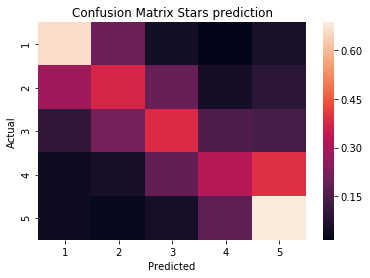

In [289]:
all_preds = np.array(all_preds)
print(all_preds.shape)
y_predictions = all_preds.argmax(axis=1)
y_true = y_true[:len(y_predictions)]

cm = ConfusionMatrix(y_true, y_predictions)
cm.plot(backend='seaborn', normalized=True)
plt.title('Confusion Matrix Stars prediction')
plt.figure(figsize=(12, 10))

test_correctPred = np.equal(y_predictions, y_true)
test_accuracy = np.mean(test_correctPred.astype(float))

print(test_accuracy)